In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load Result Files of all Models

In [2]:
# Dictionary zur Speicherung der Ergebnisse
results_dict = {}

# Ordner, in dem sich die CSV-Dateien befinden
folder_path = "../results"

# Überprüfen, ob der Ordner existiert
if os.path.exists(folder_path) and os.path.isdir(folder_path):
    # Alle Dateien im Ordner durchgehen
    for file_name in os.listdir(folder_path):
        # Überprüfen, ob die Datei eine CSV-Datei ist
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            try:
                # CSV-Datei einlesen
                df = pd.read_csv(file_path, parse_dates=["Datetime"], index_col="Datetime")
                df.index = pd.to_datetime(df.index, utc=True)
                df.index = df.index.tz_convert('Europe/Berlin')
                
                # Inhalt der Datei im Dictionary speichern (ohne Dateiendung als Schlüssel)
                results_dict[file_name[:-4]] = df
            except Exception as e:
                print(f"Fehler beim Einlesen der Datei {file_name}: {e}")
else:
    print("Der Ordner 'results' existiert nicht oder ist kein Verzeichnis.")

# Ergebnisse prüfen
for key, value in results_dict.items():
    print(f"{key}: {value.shape} Zeilen und Spalten")

LightGBM: (364, 6) Zeilen und Spalten
Mean Ensemble: (364, 6) Zeilen und Spalten
Median Ensemble: (364, 6) Zeilen und Spalten
Quantile_Regression: (364, 6) Zeilen und Spalten
Quantile_Regression_Forest: (364, 6) Zeilen und Spalten
XGBoost: (364, 6) Zeilen und Spalten


#### Quantile Loss Overview

In [3]:
#results_dict["Median Ensemble"].columns

In [4]:
# Berechnung des Quantile Loss
quantile_loss_dict = {}
for key, df in results_dict.items():
    quantiles = [col for col in df.columns if col.startswith("q")]
    target = df["target"].values

    # Neues DataFrame basierend auf dem Original erstellen
    loss_df = df.copy()

    for q_col in quantiles:
        q = float(q_col[1:])  # Quantil-Wert aus dem Spaltennamen extrahieren
        y_pred = df[q_col].values
        loss = np.where(y_pred > target, 
                        (1 - q) * (y_pred - target), 
                         q * (target - y_pred))
        loss_df[q_col] = loss

    # Loss-DataFrame in das Dictionary speichern
    quantile_loss_dict[key] = loss_df

In [5]:
# Schritt 1: Durchschnittlichen Quantilverlust pro Modell berechnen
summary_rows = []

for model_name, loss_df in quantile_loss_dict.items():
    quantile_cols = [col for col in loss_df.columns if col.startswith("q")]
    
    # Durchschnitt pro Quantil
    avg_losses = loss_df[quantile_cols].mean()
    
    # Summierter Loss über alle Quantile
    total_loss = avg_losses.sum()
    
    # Zeile mit Modellname, einzelnen Durchschnittswerten und Gesamtsumme
    row = avg_losses.to_dict()
    row['Total Average Loss'] = total_loss
    row['Model'] = model_name
    
    summary_rows.append(row)

# Schritt 2: In DataFrame umwandeln und sortieren
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index('Model')
summary_df = summary_df[sorted([col for col in summary_df.columns if col.startswith("q")]) + ['Total Average Loss']]

# Sortieren nach 'Summe' absteigend (größter Verlust oben = schlechtestes Modell)
summary_df = summary_df.sort_values(by='Total Average Loss', ascending=False)

summary_df = summary_df.round(2)

In [6]:
summary_df

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss
Model,,,,,,
Quantile_Regression,55.24,237.19,284.18,241.38,53.41,871.41
Quantile_Regression_Forest,42.46,158.92,184.14,171.57,52.36,609.45
XGBoost,43.86,141.61,173.87,147.83,46.66,553.83
Mean Ensemble,41.68,143.38,169.34,150.11,42.36,546.88
Median Ensemble,41.68,143.38,169.34,150.11,42.36,546.88
LightGBM,39.91,145.49,166.86,152.99,38.07,543.31


#### Qauntil Coverage Overview

In [7]:
# Covergae by

coverage_dict = {}

for model_name, df in results_dict.items():
    quantiles = [col for col in df.columns if col.startswith("q")]
    target = df["target"].values
    coverage_df = pd.DataFrame(index=df.index)

    for q_col in quantiles:
        preds = df[q_col].values
        coverage_df[q_col] = (target <= preds).astype(int)

    coverage_dict[model_name] = coverage_df

In [8]:
#coverage_dict["Median Ensemble"].describe()

In [9]:
coverage_rows = []

for model_name, coverage_df in coverage_dict.items():
    avg_coverage = coverage_df.mean()
    row = avg_coverage.to_dict()
    row["Modell"] = model_name
    coverage_rows.append(row)

coverage_summary = pd.DataFrame(coverage_rows)
coverage_summary = coverage_summary.set_index("Modell")
coverage_summary = coverage_summary[sorted(coverage_summary.columns)]


In [10]:
coverage_summary.round(2)

,q0.025,q0.25,q0.5,q0.75,q0.975
Modell,,,,,
LightGBM,0.01,0.20,0.56,0.87,1.0
Mean Ensemble,0.01,0.21,0.57,0.87,1.0
Median Ensemble,0.01,0.21,0.57,0.87,1.0
Quantile_Regression,0.01,0.12,0.50,0.81,1.0
Quantile_Regression_Forest,0.00,0.12,0.53,0.90,1.0
XGBoost,0.01,0.22,0.56,0.87,1.0


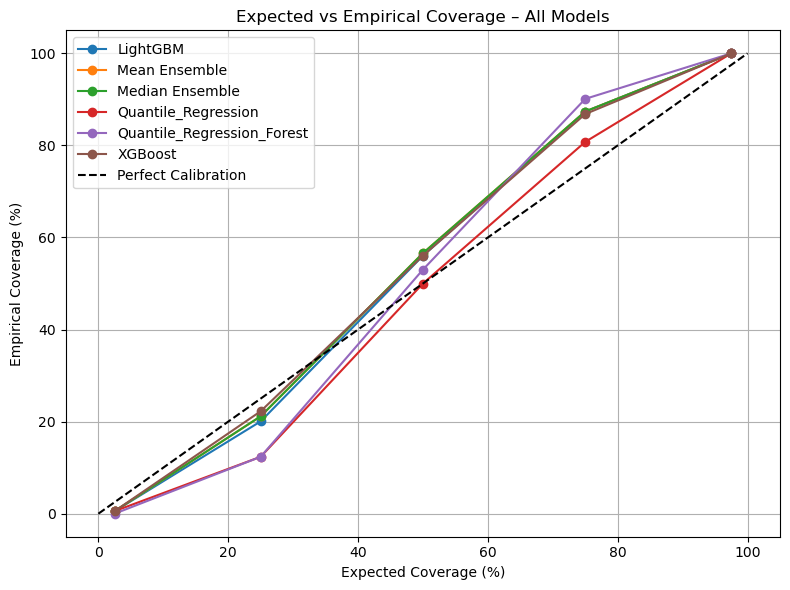

In [11]:
plt.figure(figsize=(8, 6))

# Corrected: multiply by 100 for percentage
expected_coverages = [float(col[1:]) * 100 for col in coverage_summary.columns]

# Plot for each model
for model_name, row in coverage_summary.iterrows():
    plt.plot(expected_coverages, row.values * 100, marker='o', label=model_name)

# Perfect Calibration line
plt.plot([0, 100], [0, 100], linestyle='--', color='black', label="Perfect Calibration")

plt.xlabel("Expected Coverage (%)")
plt.ylabel("Empirical Coverage (%)")
plt.title("Expected vs Empirical Coverage – All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# Define expected coverage values per quantile (from column names)
expected_coverage = {col: float(col[1:]) for col in coverage_summary.columns}

# Compute deviation: expected - empirical
calibration_deviation = pd.DataFrame(index=coverage_summary.index)

for col in coverage_summary.columns:
    calibration_deviation[col] = expected_coverage[col] - coverage_summary[col]

# Optional: round for readability
calibration_deviation = calibration_deviation.round(2)


In [13]:
calibration_deviation

,q0.025,q0.25,q0.5,q0.75,q0.975
Modell,,,,,
LightGBM,0.02,0.05,-0.06,-0.12,-0.03
Mean Ensemble,0.02,0.04,-0.07,-0.12,-0.03
Median Ensemble,0.02,0.04,-0.07,-0.12,-0.03
Quantile_Regression,0.02,0.13,0.00,-0.06,-0.03
Quantile_Regression_Forest,0.02,0.13,-0.03,-0.15,-0.03
XGBoost,0.02,0.03,-0.06,-0.12,-0.03


#### Interval Coverage

In [14]:
interval_coverage_rows = []

for model_name, df in results_dict.items():
    lower_95 = df["q0.025"]
    upper_95 = df["q0.975"]
    lower_50 = df["q0.25"]
    upper_50 = df["q0.75"]
    target = df["target"]

    coverage_95 = ((target >= lower_95) & (target <= upper_95)).mean()
    coverage_50 = ((target >= lower_50) & (target <= upper_50)).mean()

    interval_coverage_rows.append({
        "Modell": model_name,
        "CI_50 Coverage": coverage_50,
        "CI_95 Coverage": coverage_95
    })

interval_coverage_df = pd.DataFrame(interval_coverage_rows)
interval_coverage_df = interval_coverage_df.set_index("Modell").round(2)


In [15]:
interval_coverage_df

,CI_50 Coverage,CI_95 Coverage
Modell,,
LightGBM,0.67,0.99
Mean Ensemble,0.66,0.99
Median Ensemble,0.66,0.99
Quantile_Regression,0.69,0.99
Quantile_Regression_Forest,0.78,1.00
XGBoost,0.65,0.99


#### Quantile Loss and Coverage

In [16]:
quantile_loss_ci_coverage = summary_df.copy()
quantile_loss_ci_coverage = quantile_loss_ci_coverage.join(interval_coverage_df)

In [17]:
quantile_loss_ci_coverage

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage
Model,,,,,,,,
Quantile_Regression,55.24,237.19,284.18,241.38,53.41,871.41,0.69,0.99
Quantile_Regression_Forest,42.46,158.92,184.14,171.57,52.36,609.45,0.78,1.00
XGBoost,43.86,141.61,173.87,147.83,46.66,553.83,0.65,0.99
Mean Ensemble,41.68,143.38,169.34,150.11,42.36,546.88,0.66,0.99
Median Ensemble,41.68,143.38,169.34,150.11,42.36,546.88,0.66,0.99
LightGBM,39.91,145.49,166.86,152.99,38.07,543.31,0.67,0.99


##### Model Results Visualization

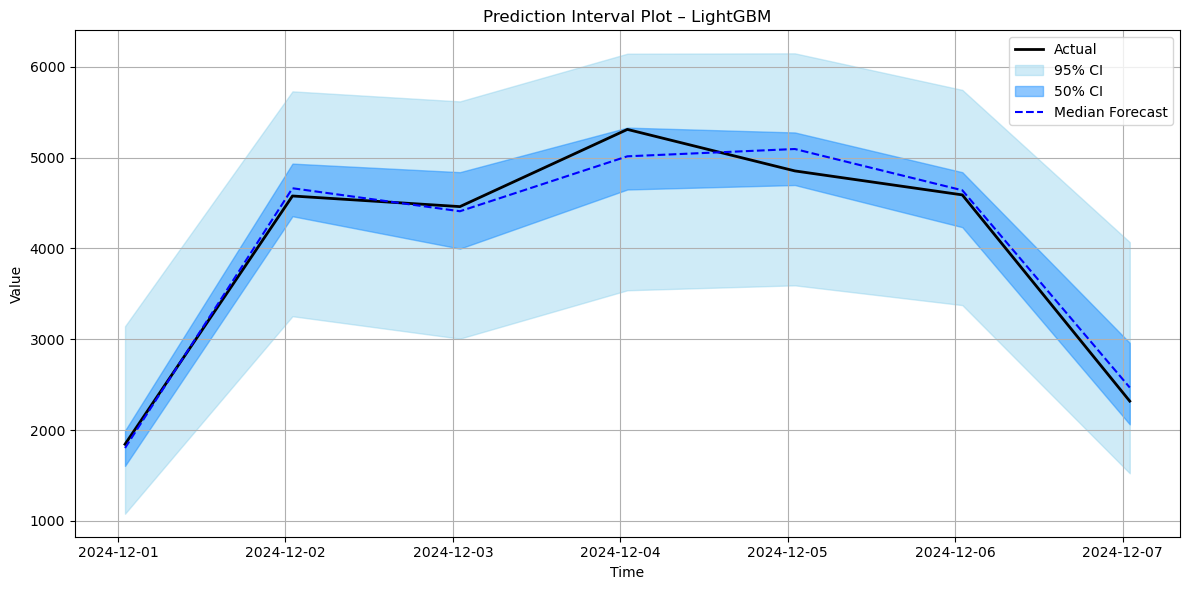

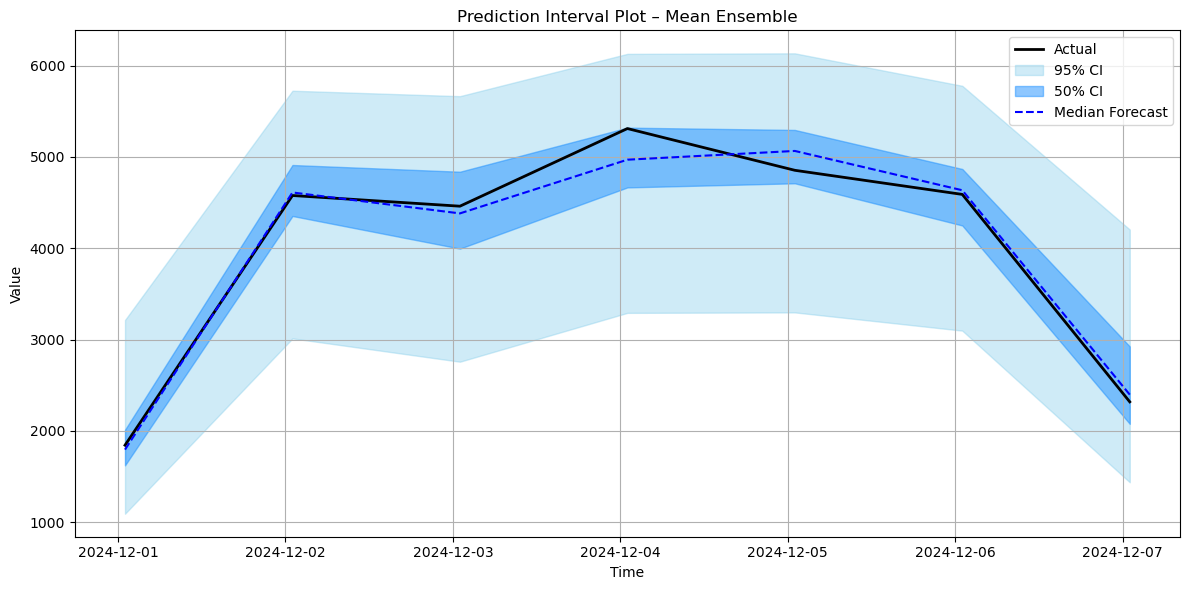

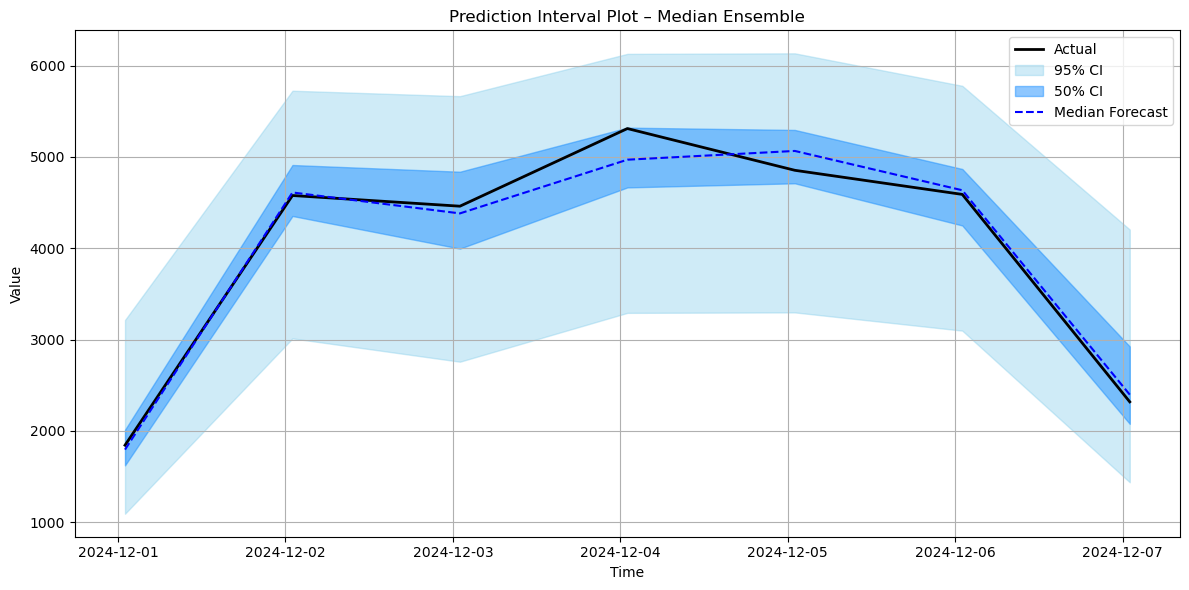

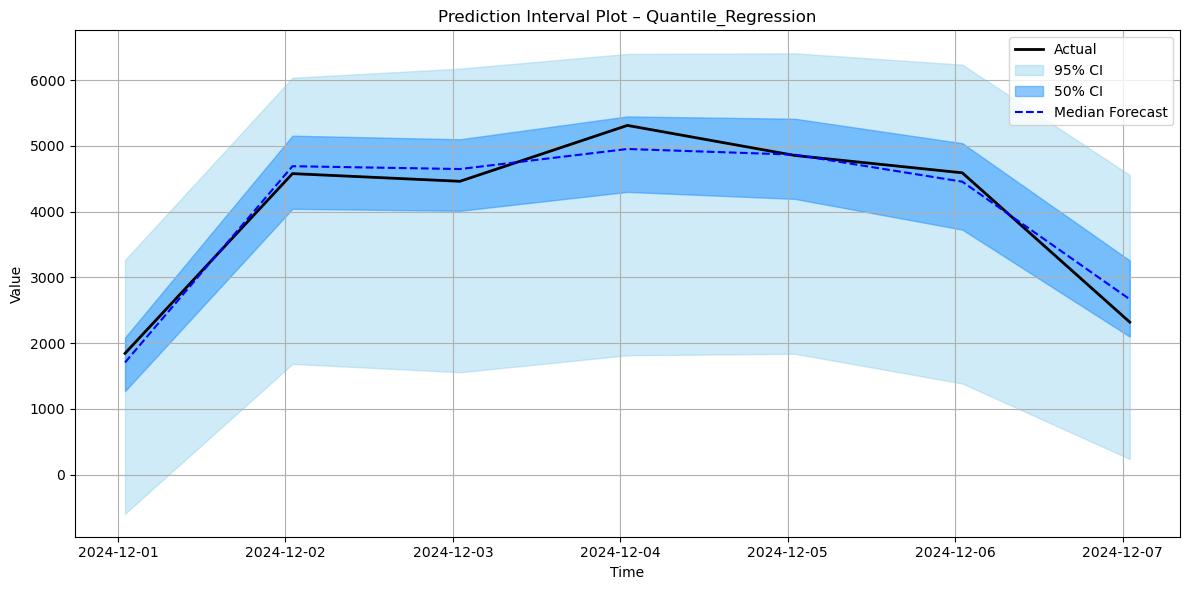

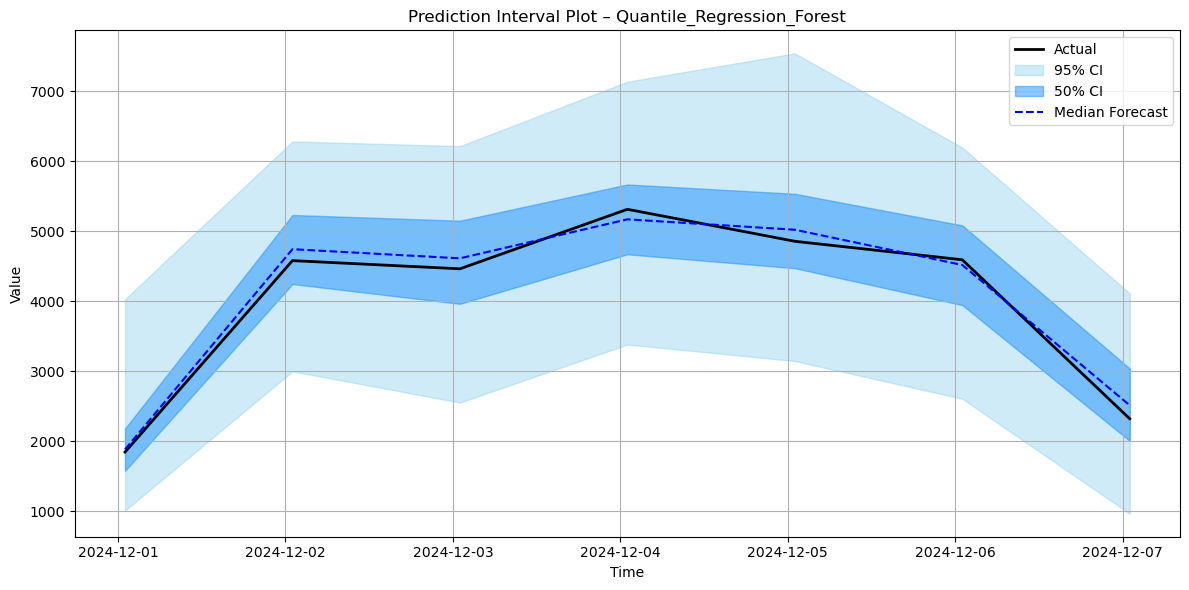

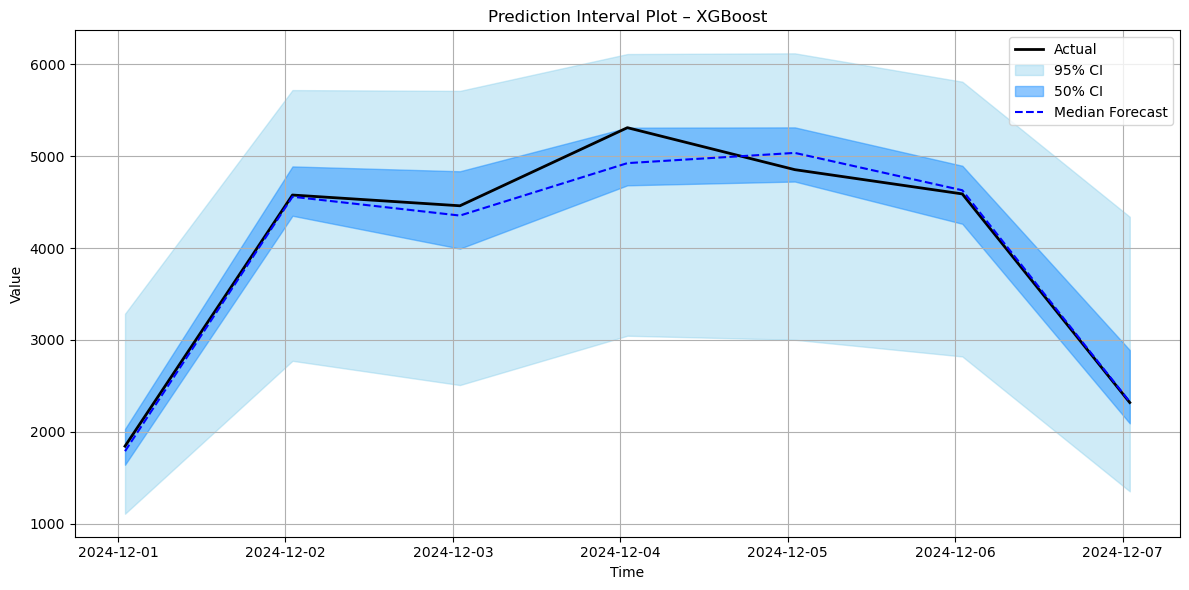

In [18]:
# Set start and end date here
start_date = "2024-12-01"
end_date = "2024-12-07"

for model_name, df in results_dict.items():
    # Filter by date range
    df_range = df.loc[start_date:end_date]

    plt.figure(figsize=(12, 6))

    x = df_range.index
    y_actual = df_range["target"]
    q025 = df_range["q0.025"]
    q975 = df_range["q0.975"]
    q25 = df_range["q0.25"]
    q75 = df_range["q0.75"]
    q50 = df_range["q0.5"]

    plt.plot(x, y_actual, color="black", label="Actual", linewidth=2)
    plt.fill_between(x, q025, q975, color="skyblue", alpha=0.4, label="95% CI")
    plt.fill_between(x, q25, q75, color="dodgerblue", alpha=0.5, label="50% CI")
    plt.plot(x, q50, color="blue", linestyle="--", label="Median Forecast")

    plt.title(f"Prediction Interval Plot – {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### PIT Plots

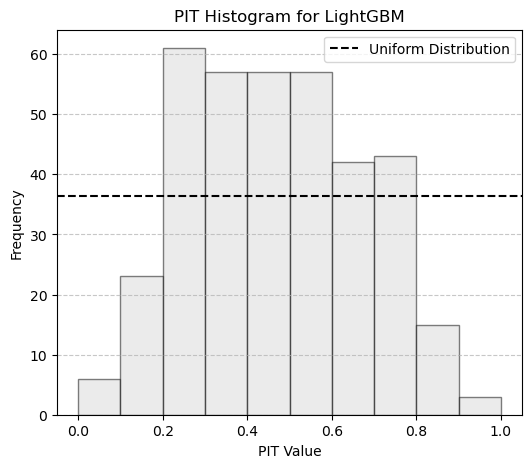

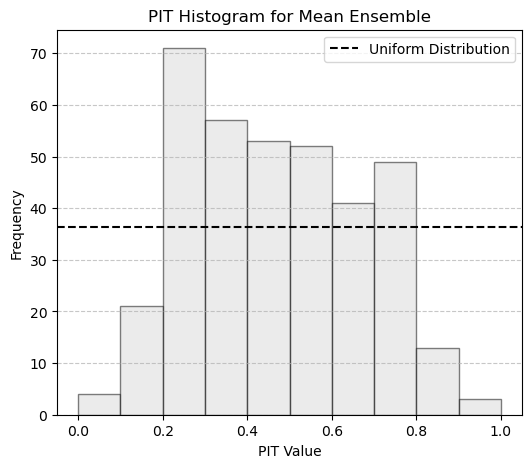

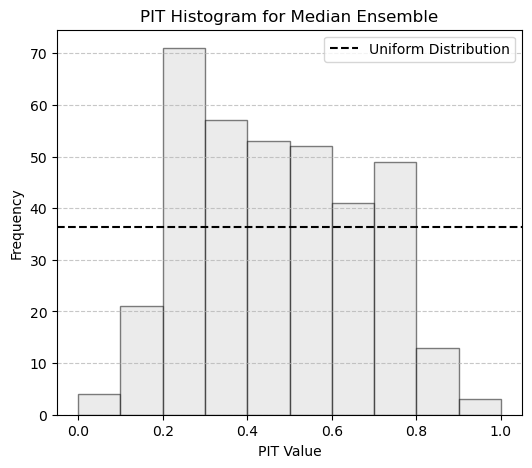

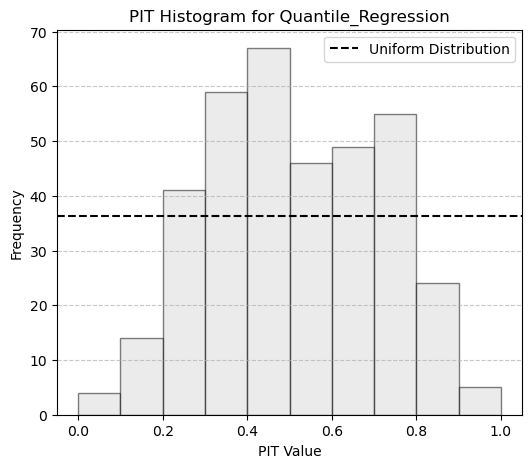

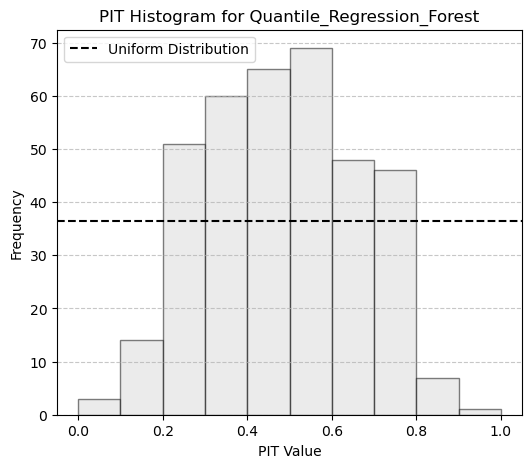

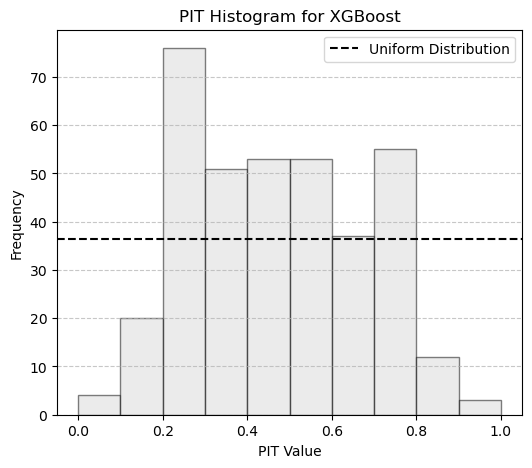

In [19]:
# Funktion zur Berechnung des PIT-Werts pro Zeile
def calculate_pit(row):
    # Zielwert und Quantilwerte extrahieren
    y_target = row['target']
    quantiles = [row['q0.025'], row['q0.25'], row['q0.5'], row['q0.75'], row['q0.975']]
    tau = [0.025, 0.25, 0.5, 0.75, 0.975]  # Wahrscheinlichkeiten
    
    # Falls der Zielwert unterhalb des niedrigsten Quantils liegt
    if y_target <= quantiles[0]:
        return 0.0
    # Falls der Zielwert oberhalb des höchsten Quantils liegt
    elif y_target >= quantiles[-1]:
        return 1.0
    # Falls der Zielwert zwischen zwei Quantilen liegt: Lineare Interpolation
    for i in range(len(quantiles) - 1):
        if quantiles[i] <= y_target <= quantiles[i + 1]:
            return tau[i] + (y_target - quantiles[i]) / (quantiles[i + 1] - quantiles[i]) * (tau[i + 1] - tau[i])
    return np.nan  # Sicherheitshalber, falls ein Wert fehlt

# Funktion zur Erstellung eines PIT-Histogramms
def plot_pit_histogram_for_dict(results_dict):
    for model_name, df in results_dict.items():
        # PIT-Werte berechnen
        df['PIT'] = df.apply(calculate_pit, axis=1)
        
        # PIT-Histogramm erstellen
        plt.figure(figsize=(6, 5))
        plt.hist(df['PIT'].dropna(), bins=10, range=(0, 1), edgecolor='black', alpha=0.5, color='#D9D9D9')
        plt.title(f'PIT Histogram for {model_name}')
        plt.xlabel('PIT Value')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.axhline(y=len(df['PIT']) / 10, color='black', linestyle='--', label='Uniform Distribution')
        plt.legend()
        plt.show()

# Beispielaufruf
# Ersetze 'horizon_results_dict' durch dein Dictionary mit DataFrames
plot_pit_histogram_for_dict(results_dict)

In [20]:
"""""

SyntaxError: EOF while scanning triple-quoted string literal (2603283466.py, line 1)

#### Quantile Loss x2 berechnen

In [ ]:
# Berechnung des Quantile Loss
quantile_loss_dict = {}
for key, df in results_dict.items():
    quantiles = [col for col in df.columns if col.startswith("q")]
    target = df["target"].values

    # Neues DataFrame basierend auf dem Original erstellen
    loss_df = df.copy()

    for q_col in quantiles:
        q = float(q_col[1:])  # Quantil-Wert aus dem Spaltennamen extrahieren
        y_pred = df[q_col].values
        loss = np.where(y_pred > target, 
                        2 * (1 - q) * (y_pred - target), 
                        2 * q * (target - y_pred))
        loss_df[q_col] = loss

    # Loss-DataFrame in das Dictionary speichern
    quantile_loss_dict[key] = loss_df


In [ ]:
quantile_loss_dict["XGBoost"].describe()

#### Horizonte Filtern

In [ ]:
# Neues Dictionary zur Speicherung der gefilterten Ergebnisse
horizon_loss_dict = {}

# Target-Horizons mit den entsprechenden Stundenbezeichnungen
target_horizons = [
    {"dayofweek": 4, "hour": 12, "horizon": "36"},  # Freitag 12:00 Stunde: 36 
    {"dayofweek": 4, "hour": 16, "horizon": "40"},  # Freitag 16:00 Stunde: 40
    {"dayofweek": 4, "hour": 20, "horizon": "44"},  # Freitag 20:00 Stunde: 44
    {"dayofweek": 5, "hour": 12, "horizon": "60"},  # Samstag 12:00 Stunde: 60
    {"dayofweek": 5, "hour": 16, "horizon": "64"},  # Samstag 16:00 Stunde: 64
    {"dayofweek": 5, "hour": 20, "horizon": "68"},  # Samstag 20:00 Stunde: 68
]

# Für jedes DataFrame im quantile_loss_dict filtern
for key, df in quantile_loss_dict.items():
    # Sicherstellen, dass der Index ein DatetimeIndex ist
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Hilfsspalten für Tag der Woche und Stunde erstellen
    df["dayofweek"] = df.index.dayofweek
    df["hour"] = df.index.hour

    # Leeres DataFrame für gefilterte Ergebnisse
    filtered_df = pd.DataFrame()

    for mapping in target_horizons:
        day = mapping["dayofweek"]
        hour = mapping["hour"]
        horizon = mapping["horizon"]

        # Zeilen filtern, die den Bedingungen entsprechen
        subset = df[(df["dayofweek"] == day) & (df["hour"] == hour)].copy()
        subset["horizon"] = horizon  # Spalte "horizon" hinzufügen

        # Gefilterte Zeilen anhängen
        filtered_df = pd.concat([filtered_df, subset])
        filtered_df = filtered_df.drop(columns=["dayofweek", "hour"])  # Hilfsspalten entfernen

    # Gefiltertes DataFrame im neuen Dictionary speichern
    horizon_loss_dict[key] = filtered_df

# Ergebnisse prüfen
for key, value in horizon_loss_dict.items():
    print(f"{key}: {value.shape} Zeilen und Spalten")


In [ ]:
horizon_loss_dict

#### Quantile Loss Summe über Quantile und dann Durchschnitt über Horizons

In [ ]:
# Neues Dictionary zur Speicherung der aggregierten Ergebnisse
aggregated_loss_dict = {}

# Berechnung der Summe der Quantile-Verluste und Aggregation nach Horizon
for key, df in horizon_loss_dict.items():
    # Summe der Quantile-Verluste berechnen
    quantile_columns = [col for col in df.columns if col.startswith("q")]
    df["total_quantile_loss"] = df[quantile_columns].sum(axis=1)

    # Nach Horizon gruppieren und Durchschnitt berechnen
    aggregated_df = df.groupby("horizon")["total_quantile_loss"].mean().reset_index()

    # Ergebnis speichern
    aggregated_loss_dict[key] = aggregated_df

# Ergebnisse prüfen
for key, value in aggregated_loss_dict.items():
    print(f"{key}: {value.shape} Zeilen und Spalten")


In [ ]:
# Gemeinsames DataFrame erstellen
merged_df = None

for key, df in aggregated_loss_dict.items():
    # Spaltennamen anpassen
    df = df.rename(columns={"total_quantile_loss": key})

    if merged_df is None:
        # Erstes DataFrame initialisieren
        merged_df = df
    else:
        # Spalten an das gemeinsame DataFrame anhängen
        merged_df = pd.merge(merged_df, df, on="horizon", how="outer")

merged_df

# Spaltensummen berechnen
final_score_df = merged_df.drop(columns=["horizon"]).sum()
final_score_df = final_score_df.reset_index()
final_score_df.final_score_df = ["Model", "Total Loss"]
final_score_df.set_index("index", inplace=True)
print("Spaltensummen als DataFrame:")
final_score_df

In [ ]:
plt.style.use('default')

# Überprüfe die vorhandenen Spaltennamen im DataFrame
print(final_score_df.columns)

# Falls die Spalte mit den Modellnamen keinen Namen hat, könnte sie der Index sein
# In diesem Fall setzen wir sie zurück, um sie als Spalte zu behandeln
if 'index' not in final_score_df.columns:
    final_score_df = final_score_df.reset_index()


# Sortiere das DataFrame nach den Werten in aufsteigender Reihenfolge
final_score_df_sorted = final_score_df.sort_values(by=0)

# Plotten des Balkendiagramms
plt.figure(figsize=(10, 6))
bars = plt.bar(final_score_df_sorted['index'], final_score_df_sorted[0], color='#009682', alpha=0.5)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Beschriftung der Achsen mit mathematischer Formel
plt.ylabel(r'$\sum_{h=1}^{6} \overline{S}_{W,h}$', fontsize=14)
plt.xlabel('', fontsize=12)
plt.title('Model Comparison sorted by Sum of Quantile Errors', fontsize=16)

# Waagerechte Gridlines hinzufügen
#plt.grid(axis='y', linestyle='--', alpha=0.7)  # Nur waagerechte Linien

# Werte auf den Balken hinzufügen
for bar in bars:
    value = bar.get_height()  # Höhe des Balkens (Wert)
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-Position (Mitte des Balkens)
        value - (value * 0.05),  # y-Position (leicht unterhalb der Oberkante)
        f'{value:.2f}',  # Formatierter Wert
        ha='center', va='top', fontsize=12, color='black'
    )

# Entfernen der oberen und rechten Rahmen (Spines)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Durchschnittlcihes Loss sowie Standardabweichung über alle target horizons pro Quantil

In [ ]:
# Neues DataFrame für die gesammelten Mittelwerte
quantile_means_df = pd.DataFrame()
quantile_stds_df = pd.DataFrame()

# Durch jedes DataFrame im horizon_loss_dict iterieren
for model_name, df in horizon_loss_dict.items():
    # Spalten "target" und "total_quantile_loss" droppen
    df = df.drop(columns=["target", "total_quantile_loss"])

    # Mean-Werte berechnen
    means = df.mean()
    # Standardabweichungen berechnen
    stds = df.std()

    # Nur die q-Spalten auswählen
    quantile_means = means.filter(like="q")
    quantile_stds = stds.filter(like="q")

    # Transponieren und als Spalten hinzufügen
    quantile_means_df[model_name] = quantile_means
    quantile_stds_df[model_name] = quantile_stds


In [ ]:
# Setze den Style
plt.style.use('default')

# Dein Plot
ax = quantile_means_df.plot(
    kind="bar", 
    figsize=(12, 6), 
    title="Mittlere Quantile-Verluste für jedes Modell"
)

# Titel mit Schriftgröße anpassen
ax.set_title("Average Quantile Losses for Each Model", fontsize=16)

# Y-Achsenbeschriftung mit Bruch hinzufügen
ax.set_ylabel(r"$\frac{1}{N}L_\tau(\hat{q}_\tau, y) \cdot$", fontsize=16)

# X-Achsenticks um 90 Grad drehen
plt.xticks(rotation=0)

# Schriftgröße der Achsenticks anpassen
ax.tick_params(axis='x', labelsize=14)  # Schriftgröße für X-Achsenticks
ax.tick_params(axis='y', labelsize=14)  # Schriftgröße für Y-Achsenticks

# Optimierung des Layouts
plt.tight_layout()

# Plot anzeigen
plt.show()



In [ ]:
plt.style.use('default')
quantile_stds_df.plot(kind="bar", figsize=(12, 6), title="Mittlere Quantile-Verluste für jedes Modell")

#### Quantile Loss über Validierungszeitraum

In [ ]:
print(plt.style.available)

In [ ]:
# Setze den Style
plt.style.use('fivethirtyeight')
plt.style.use('default')

# Dein Plot
ax = horizon_loss_dict["XGBoost"][
    ['q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']
].plot(
    figsize=(12, 6)
)

# Titel mit separater Schriftgröße setzen
ax.set_title(
    "Quantile Losses Median for Median Ensemble Across Energy Target Horizons",
    fontsize=16  # Schriftgröße des Titels
)

# Zusätzliche Anpassungen
ax.set_xlabel("", fontsize=16)  # Schriftgröße für X-Achse
ax.set_ylabel(r"$L_\tau(\hat{q}_\tau, y)$", fontsize=16)  # Schriftgröße für Y-Achse
ax.tick_params(axis='x', labelsize=14)  # Schriftgröße für X-Achsenticks
ax.tick_params(axis='y', labelsize=14)  # Schriftgröße für Y-Achsenticks
ax.legend(fontsize=14)  # Schriftgröße für die Legende
plt.tight_layout()  # Verhindert Überlappungen

# Plot anzeigen
plt.show()

In [ ]:
plt.style.use('default')
quantile_loss_dict["Median Ensemble"][['q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975',]].plot(figsize=(12, 6), title="Quantile-Verluste für das Mean-Ensemble")

In [ ]:
horizon_loss_dict["Mean Ensemble"]

In [ ]:
horizon_loss_dict.keys()

In [ ]:
plt.style.use('default')

# Plot für ein spezifisches Quantil (z.B. q0.5)
quantile_to_plot = "q0.5"

# Modelle, die ausgeschlossen werden sollen
excluded_models = ['Baseline_forecast', 'GradientBoostedRegressor', 'LightGBM', 'RandomForestRegressor']  # Beispiel: ["Model1", "Model2"]

plt.figure(figsize=(10, 6))

# Für jedes Modell die q0.5-Werte plotten
for model_name, df in horizon_loss_dict.items():
    if model_name not in excluded_models and quantile_to_plot in df.columns:
        # Werte nach Datetime-Index sortieren
        df = df.sort_index()
        plt.plot(df.index, df[quantile_to_plot], label=model_name)

# Plot anpassen
plt.title(f"{quantile_to_plot} Quantil für verschiedene Modelle")
plt.xlabel("Datetime")
plt.ylabel("Quantile Value")
plt.legend(title="Modelle")
plt.grid(True)
plt.tight_layout()

# Plot anzeigen
plt.show()

#### Quantil Coverage für alle Werte

In [ ]:
plt.style.use('default')
# Funktion für die Erstellung eines Quantile Coverage Plots
def plot_quantile_coverage(dataframe, model_name):
    quantile_columns = [col for col in dataframe.columns if col.startswith("q")]
    targets = dataframe["target"].values

    empirical_coverage = []
    expected_coverage = []

    for quantile in quantile_columns:
        q = float(quantile[1:])  # Extrahiere den Quantilwert aus dem Spaltennamen
        predictions = dataframe[quantile].values

        # Berechne die empirische Abdeckung
        coverage = np.mean((predictions >= targets)) * 100

        empirical_coverage.append(coverage)
        expected_coverage.append(q * 100)

    # Plot erstellen
    plt.figure(figsize=(8, 5))
    plt.plot(expected_coverage, empirical_coverage, marker='o', label=model_name)
    plt.plot([0, 100], [0, 100], linestyle="--", color="black", label="Perfect Calibration")

    plt.title(f"Expected vs Empirical Coverage for {model_name}")
    plt.xlabel("Expected Coverage (%)")
    plt.ylabel("Empirical Coverage (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Für jedes DataFrame im results_dict einen Plot erstellen
for model_name, df in results_dict.items():
    plot_quantile_coverage(df, model_name)


#### Quantile Coverage nach Horizons

In [ ]:
# Neues Dictionary zur Speicherung der gefilterten Ergebnisse
horizon_results_dict = {}

# Target-Horizons mit den entsprechenden Stundenbezeichnungen
target_horizons = [
    {"dayofweek": 4, "hour": 12, "horizon": "36"},  # Freitag 12:00 Stunde: 36 
    {"dayofweek": 4, "hour": 16, "horizon": "40"},  # Freitag 16:00 Stunde: 40
    {"dayofweek": 4, "hour": 20, "horizon": "44"},  # Freitag 20:00 Stunde: 44
    {"dayofweek": 5, "hour": 12, "horizon": "60"},  # Samstag 12:00 Stunde: 60
    {"dayofweek": 5, "hour": 16, "horizon": "64"},  # Samstag 16:00 Stunde: 64
    {"dayofweek": 5, "hour": 20, "horizon": "68"},  # Samstag 20:00 Stunde: 68
]

# Für jedes DataFrame im quantile_loss_dict filtern
for key, df in results_dict.items():
    # Sicherstellen, dass der Index ein DatetimeIndex ist
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Hilfsspalten für Tag der Woche und Stunde erstellen
    df["dayofweek"] = df.index.dayofweek
    df["hour"] = df.index.hour

    # Leeres DataFrame für gefilterte Ergebnisse
    filtered_df = pd.DataFrame()

    for mapping in target_horizons:
        day = mapping["dayofweek"]
        hour = mapping["hour"]
        horizon = mapping["horizon"]

        # Zeilen filtern, die den Bedingungen entsprechen
        subset = df[(df["dayofweek"] == day) & (df["hour"] == hour)].copy()
        subset["horizon"] = horizon  # Spalte "horizon" hinzufügen

        # Gefilterte Zeilen anhängen
        filtered_df = pd.concat([filtered_df, subset])
        filtered_df = filtered_df.drop(columns=["dayofweek", "hour"])  # Hilfsspalten entfernen

    # Gefiltertes DataFrame im neuen Dictionary speichern
    horizon_results_dict[key] = filtered_df

# Ergebnisse prüfen
for key, value in horizon_loss_dict.items():
    print(f"{key}: {value.shape} Zeilen und Spalten")

In [ ]:
plt.style.use('default')
# Funktion für die Erstellung eines Quantile Coverage Plots
def plot_quantile_coverage(dataframe, model_name):
    quantile_columns = [col for col in dataframe.columns if col.startswith("q")]
    targets = dataframe["target"].values

    empirical_coverage = []
    expected_coverage = []

    for quantile in quantile_columns:
        q = float(quantile[1:])  # Extrahiere den Quantilwert aus dem Spaltennamen
        predictions = dataframe[quantile].values

        # Berechne die empirische Abdeckung
        coverage = np.mean((predictions >= targets)) * 100

        empirical_coverage.append(coverage)
        expected_coverage.append(q * 100)

    # Plot erstellen
    plt.figure(figsize=(8, 5))
    plt.plot(expected_coverage, empirical_coverage, marker='o', label=model_name)
    plt.plot([0, 100], [0, 100], linestyle="--", color="black", label="Perfect Calibration")

    plt.title(f"Expected vs Empirical Coverage for {model_name}")
    plt.xlabel("Expected Coverage (%)")
    plt.ylabel("Empirical Coverage (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Für jedes DataFrame im results_dict einen Plot erstellen
for model_name, df in horizon_results_dict.items():
    plot_quantile_coverage(df, model_name)


#### Quantil Coverage pro Horizont

In [ ]:
# Funktion für die Erstellung eines Quantile Coverage Plots mit Berücksichtigung von Horizonten
def plot_quantile_coverage_by_horizon(dataframe, model_name):
    quantile_columns = [col for col in dataframe.columns if col.startswith("q")]
    targets = dataframe["target"].values
    horizons = dataframe["horizon"].unique()  # Einzigartige Horizonte

    plt.figure(figsize=(10, 6))

    # Schleife durch die Horizonte und erstelle für jeden eine Linie
    for horizon in horizons:
        df_horizon = dataframe[dataframe["horizon"] == horizon]
        targets_horizon = df_horizon["target"].values
        empirical_coverage = []
        expected_coverage = []

        for quantile in quantile_columns:
            q = float(quantile[1:])  # Extrahiere den Quantilwert aus dem Spaltennamen
            predictions = df_horizon[quantile].values

            # Berechne die empirische Abdeckung
            coverage = np.mean((predictions >= targets_horizon)) * 100

            empirical_coverage.append(coverage)
            expected_coverage.append(q * 100)

        # Linie für den aktuellen Horizont hinzufügen
        plt.plot(expected_coverage, empirical_coverage, marker='o', label=f"Horizon {horizon}")

    # Perfekte Kalibrierungslinie
    plt.plot([0, 100], [0, 100], linestyle="--", color="black", label="Perfect Calibration")

    plt.title(f"Expected vs Empirical Coverage for {model_name}", fontsize=14)
    plt.xlabel("Expected Coverage (%)", fontsize=14)
    plt.ylabel("Empirical Coverage (%)",fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# Für jedes DataFrame im results_dict einen Plot erstellen
for model_name, df in horizon_results_dict.items():
    plot_quantile_coverage_by_horizon(df, model_name)


#### PIT Value Target Horizons

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Funktion zur Berechnung des PIT-Werts pro Zeile
def calculate_pit(row):
    # Zielwert und Quantilwerte extrahieren
    y_target = row['target']
    quantiles = [row['q0.025'], row['q0.25'], row['q0.5'], row['q0.75'], row['q0.975']]
    tau = [0.025, 0.25, 0.5, 0.75, 0.975]  # Wahrscheinlichkeiten
    
    # Falls der Zielwert unterhalb des niedrigsten Quantils liegt
    if y_target <= quantiles[0]:
        return 0.0
    # Falls der Zielwert oberhalb des höchsten Quantils liegt
    elif y_target >= quantiles[-1]:
        return 1.0
    # Falls der Zielwert zwischen zwei Quantilen liegt: Lineare Interpolation
    for i in range(len(quantiles) - 1):
        if quantiles[i] <= y_target <= quantiles[i + 1]:
            return tau[i] + (y_target - quantiles[i]) / (quantiles[i + 1] - quantiles[i]) * (tau[i + 1] - tau[i])
    return np.nan  # Sicherheitshalber, falls ein Wert fehlt

# Funktion zur Erstellung eines PIT-Histogramms
def plot_pit_histogram_for_dict(horizon_results_dict):
    for model_name, df in horizon_results_dict.items():
        # PIT-Werte berechnen
        df['PIT'] = df.apply(calculate_pit, axis=1)
        
        # PIT-Histogramm erstellen
        plt.figure(figsize=(6, 5))
        plt.hist(df['PIT'].dropna(), bins=10, range=(0, 1), edgecolor='black', alpha=0.5, color='#D9D9D9')
        plt.title(f'PIT Histogram for {model_name}')
        plt.xlabel('PIT Value')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.axhline(y=len(df['PIT']) / 10, color='black', linestyle='--', label='Uniform Distribution')
        plt.legend()
        plt.show()

# Beispielaufruf
# Ersetze 'horizon_results_dict' durch dein Dictionary mit DataFrames
plot_pit_histogram_for_dict(horizon_results_dict)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Funktion zur Berechnung des PIT-Werts pro Zeile
def calculate_pit(row):
    # Zielwert und Quantilwerte extrahieren
    y_target = row['target']
    quantiles = [row['q0.025'], row['q0.25'], row['q0.5'], row['q0.75'], row['q0.975']]
    tau = [0.025, 0.25, 0.5, 0.75, 0.975]  # Wahrscheinlichkeiten
    
    # Falls der Zielwert unterhalb des niedrigsten Quantils liegt
    if y_target <= quantiles[0]:
        return 0.0
    # Falls der Zielwert oberhalb des höchsten Quantils liegt
    elif y_target >= quantiles[-1]:
        return 1.0
    # Falls der Zielwert zwischen zwei Quantilen liegt: Lineare Interpolation
    for i in range(len(quantiles) - 1):
        if quantiles[i] <= y_target <= quantiles[i + 1]:
            return tau[i] + (y_target - quantiles[i]) / (quantiles[i + 1] - quantiles[i]) * (tau[i + 1] - tau[i])
    return np.nan  # Sicherheitshalber, falls ein Wert fehlt

# Funktion zur Erstellung eines PIT-Histogramms
def plot_pit_histogram_for_dict(horizon_results_dict):
    for model_name, df in horizon_results_dict.items():
        # PIT-Werte berechnen
        df['PIT'] = df.apply(calculate_pit, axis=1)
        
        # PIT-Histogramm erstellen
        plt.figure(figsize=(6, 5))
        plt.hist(df['PIT'].dropna(), bins=10, range=(0, 1), edgecolor='black', alpha=0.5, color='#D9D9D9')
        plt.title(f'PIT Histogram for {model_name}')
        plt.xlabel('PIT Value')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.axhline(y=len(df['PIT']) / 10, color='black', linestyle='--', label='Uniform Distribution')
        plt.legend()
        plt.show()

# Beispielaufruf
# Ersetze 'horizon_results_dict' durch dein Dictionary mit DataFrames
plot_pit_histogram_for_dict(results_dict)

#### Quantile Coverage Including Std

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Funktion für die Erstellung eines Quantile Coverage Plots mit Standardabweichung
def plot_quantile_coverage_with_std(dataframe, model_name):
    quantile_columns = [col for col in dataframe.columns if col.startswith("q")]
    targets = dataframe["target"].values

    empirical_coverage = []
    expected_coverage = []
    std_deviation = []

    for quantile in quantile_columns:
        q = float(quantile[1:])  # Extrahiere den Quantilwert aus dem Spaltennamen
        predictions = dataframe[quantile].values

        # Berechne die empirische Abdeckung
        coverage = (predictions >= targets).astype(float)
        empirical_mean = np.mean(coverage) * 100
        empirical_std = np.std(coverage) * 100 * q * (1 - q)  # Berücksichtige die Größe des Quantils

        empirical_coverage.append(empirical_mean)
        expected_coverage.append(q * 100)
        std_deviation.append(empirical_std)

    # Plot erstellen
    plt.figure(figsize=(8, 5))
    plt.errorbar(expected_coverage, empirical_coverage, yerr=std_deviation, fmt='o', label=model_name, capsize=5)
    plt.plot([0, 100], [0, 100], linestyle="--", color="black", label="Perfect Calibration")

    plt.title(f"Expected vs Empirical Coverage with Std for {model_name}")
    plt.xlabel("Expected Coverage (%)")
    plt.ylabel("Empirical Coverage (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Für jedes DataFrame im results_dict einen erweiterten Plot erstellen
for model_name, df in results_dict.items():
    plot_quantile_coverage_with_std(df, model_name)

